Data collection file can be found here -> https://github.com/trashsock/comp_sci_7417_UoA/blob/main/Data_Collection.ipynb

## Imports

In [ ]:
# !pip install KeyBERT

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 53.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [ ]:
import pandas as pd
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from openpyxl import load_workbook
import os
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import seaborn as sns
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
# from keybert import KeyBERT

# Download required NLTK data
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## Pre-processing

In [ ]:
# Loading the dataset
EXCEL_FILE = "/content/nlp_stackoverflow_dataset.xlsx"
df_raw = pd.read_excel(EXCEL_FILE, sheet_name="Raw_Data")

# Define text columns for preprocessing
text_columns = ['title', 'description', 'tags', 'accepted_answer', 'more_answers',
                'post_username', 'accepted_answer_user', 'more_answers_user']

# Step 1: Removing duplicates based on 'title' and 'description'
df_no_duplicates = df_raw.drop_duplicates(subset=['title', 'description'], keep='first')
print(f"Removed duplicates. Original rows: {len(df_raw)}, After duplicate removal: {len(df_no_duplicates)}")

# Step 2: Removing rows where 'accepted_answer' is "No accepted answer"
df_no_empty_answers = df_no_duplicates[df_no_duplicates['accepted_answer'] != 'No accepted answer']
print(f"Removed rows with 'No accepted answer'. Remaining rows: {len(df_no_empty_answers)}")

# Step 3: Converting to lowercase
df_lowercase = df_no_empty_answers.copy()
for column in text_columns:
    df_lowercase[column] = df_lowercase[column].astype(str).str.lower()
print("Step 3: Converted text to lowercase")

# Step 4: Removing HTML tags
df_no_html = df_lowercase.copy()
def remove_html_tags(text):
    if isinstance(text, str):
        return re.sub(r'<[^>]+>', '', text)
    return text

for column in ['title', 'description', 'accepted_answer', 'more_answers']:
    df_no_html[column] = df_no_html[column].apply(remove_html_tags)
print("Step 4: Removed HTML tags (<p> and others)")

# Step 5: Removing punctuation, special symbols, and '39' (from raw data)
df_no_punctuation = df_no_html.copy()
def remove_punctuation(text):
    if isinstance(text, str):
        # Removing '39' (representing single quote in raw data)
        text = re.sub(r'\b39\b', '', text)
        # Removing punctuation and special symbols
        return re.sub(r'[^\w\s]', '', text)
    return text

for column in text_columns:
    df_no_punctuation[column] = df_no_punctuation[column].apply(remove_punctuation)
print("Step 5: Removed punctuation, special symbols, and '39' from raw data")

# Step 6: Tokenization
df_tokenized = df_no_punctuation.copy()
def tokenize_text(text):
    if isinstance(text, str):
        return ' '.join(word_tokenize(text))
    return text

for column in ['title', 'description', 'accepted_answer', 'more_answers']:
    df_tokenized[column] = df_tokenized[column].apply(tokenize_text)
print("Step 6: Tokenized text")

# Step 7: Removing stop words
df_no_stopwords = df_tokenized.copy()
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    if isinstance(text, str):
        tokens = word_tokenize(text)
        return ' '.join([word for word in tokens if word not in stop_words])
    return text

for column in ['title', 'description', 'accepted_answer', 'more_answers']:
    df_no_stopwords[column] = df_no_stopwords[column].apply(remove_stopwords)
print("Step 7: Removed stop words")

# Step 8: Lemmatization
df_preprocessed = df_no_stopwords.copy()
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    if isinstance(text, str):
        tokens = word_tokenize(text)
        return ' '.join([lemmatizer.lemmatize(word) for word in tokens])
    return text

for column in ['title', 'description', 'accepted_answer', 'more_answers']:
    df_preprocessed[column] = df_preprocessed[column].apply(lemmatize_text)
print("Step 8: Applied lemmatization")

# Step 9: Creating output Excel file with separate sheets for each step
OUTPUT_FILE = "nlp_stackoverflow_processed.xlsx"
with pd.ExcelWriter(OUTPUT_FILE, engine='openpyxl') as writer:
    df_raw.to_excel(writer, sheet_name='Raw_Data', index=False)
    df_no_duplicates.to_excel(writer, sheet_name='No_Duplicates', index=False)
    df_no_empty_answers.to_excel(writer, sheet_name='No_Empty_Answers', index=False)
    df_lowercase.to_excel(writer, sheet_name='Lowercase', index=False)
    df_no_html.to_excel(writer, sheet_name='No_HTML', index=False)
    df_no_punctuation.to_excel(writer, sheet_name='No_Punctuation', index=False)
    df_tokenized.to_excel(writer, sheet_name='Tokenized', index=False)
    df_no_stopwords.to_excel(writer, sheet_name='No_Stopwords', index=False)
    df_preprocessed.to_excel(writer, sheet_name='Preprocessed_Data', index=False)

print(f"Saved all preprocessing steps to '{OUTPUT_FILE}'")

Removed duplicates. Original rows: 20938, After duplicate removal: 20709
Removed rows with 'No accepted answer'. Remaining rows: 7750
Step 3: Converted text to lowercase
Step 4: Removed HTML tags (<p> and others)
Step 5: Removed punctuation, special symbols, and '39' from raw data
Step 6: Tokenized text
Step 7: Removed stop words
Step 8: Applied lemmatization
Saved all preprocessing steps to 'nlp_stackoverflow_processed.xlsx'


## Graphical visualisations

In [ ]:
# Set Seaborn style for consistent, professional aesthetics
sns.set_style("whitegrid")
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.dpi': 100
})


In [ ]:
# Visualization
# Visualization directory
if not os.path.exists('visualizations'):
    os.makedirs('visualizations')

# Convert date columns to datetime
df_raw['post_date'] = pd.to_datetime(df_raw['post_date'], errors='coerce')
df_raw['accepted_answer_date'] = pd.to_datetime(df_raw['accepted_answer_date'], errors='coerce')

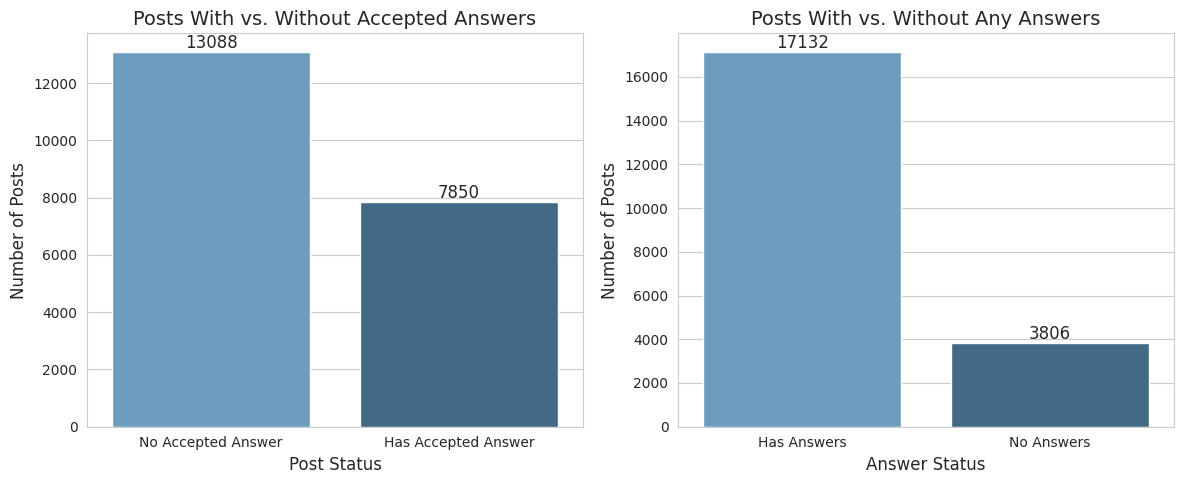

In [ ]:
# ==================== Combined Posts with vs. without Accepted Answers and Any Answers ====================
has_accepted = df_raw['accepted_answer'] != 'No accepted answer'
acceptance_counts = has_accepted.value_counts()
no_answers = (df_raw['accepted_answer'] == 'No accepted answer') & (df_raw['more_answers'] == 'No additional answers')
no_answers_counts = no_answers.value_counts()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Posts with vs. without Accepted Answers
sns.barplot(x=acceptance_counts.index.map({True: 'Has Accepted Answer', False: 'No Accepted Answer'}),
            y=acceptance_counts.values, hue=acceptance_counts.index.map({True: 'Has Accepted Answer', False: 'No Accepted Answer'}),
            palette='Blues_d', legend=False, ax=ax1)
ax1.set_title('Posts With vs. Without Accepted Answers')
ax1.set_xlabel('Post Status')
ax1.set_ylabel('Number of Posts')
for p in ax1.patches:
    ax1.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='bottom')

# Posts with vs. without Any Answers
sns.barplot(x=no_answers_counts.index.map({True: 'No Answers', False: 'Has Answers'}),
            y=no_answers_counts.values, hue=no_answers_counts.index.map({True: 'No Answers', False: 'Has Answers'}),
            palette='Blues_d', legend=False, ax=ax2)
ax2.set_title('Posts With vs. Without Any Answers')
ax2.set_xlabel('Answer Status')
ax2.set_ylabel('Number of Posts')
for p in ax2.patches:
    ax2.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='bottom')

plt.tight_layout()
plt.savefig('visualizations/7_answer_status_combined.png')
plt.show()
plt.close()

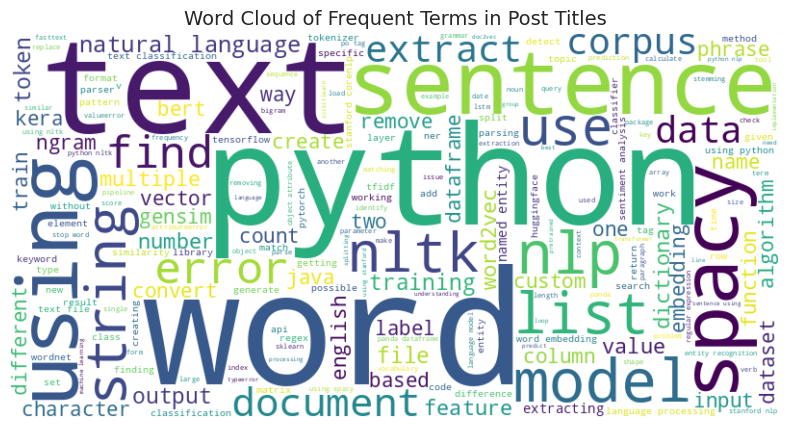

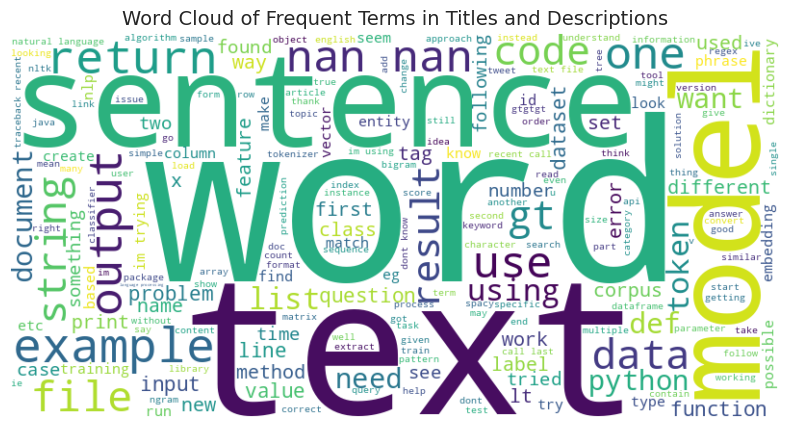

In [ ]:

# ==================== Word Cloud ====================
title_text = ' '.join(df_preprocessed['title'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(title_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Frequent Terms in Post Titles')
plt.savefig('visualizations/1_wordcloud_titles.png')
plt.show()
plt.close()

# Combined word cloud (titles + descriptions)
combined_text = ' '.join(df_preprocessed['title'].dropna()) + ' ' + ' '.join(df_preprocessed['description'].dropna())
wordcloud_combined = WordCloud(width=800, height=400, background_color='white',
                               max_words=200, collocations=True, colormap='viridis').generate(combined_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_combined, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Frequent Terms in Titles and Descriptions')
plt.savefig('visualizations/2_wordcloud_combined.png')
plt.show()
plt.close()

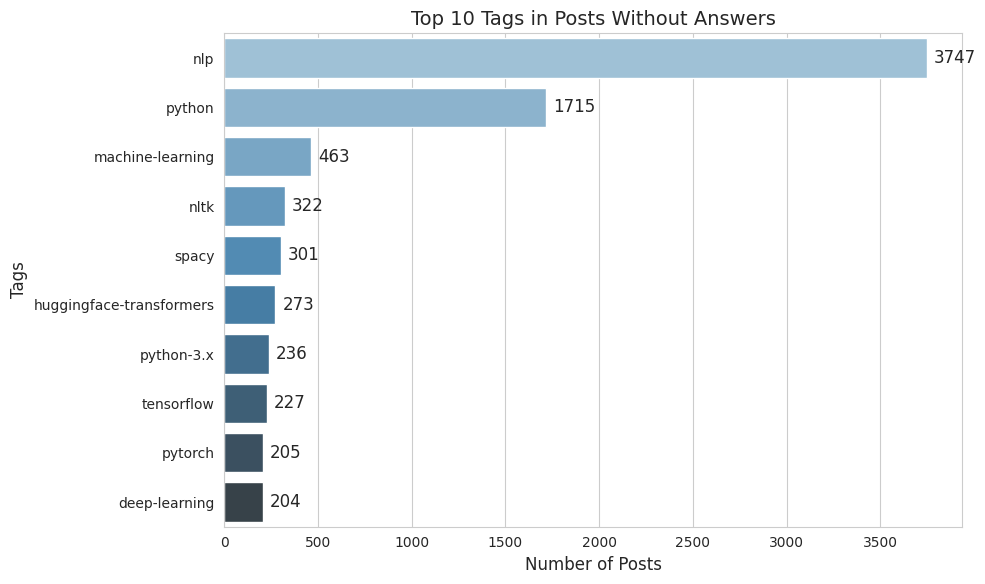

In [ ]:
# ==================== Topics Without Answers ====================
no_answers_df = df_raw[no_answers]
no_answers_tags = no_answers_df['tags'].str.split(';', expand=True).stack().value_counts().head(10)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=no_answers_tags.values, y=no_answers_tags.index, hue=no_answers_tags.index, palette='Blues_d', legend=False)
plt.title('Top 10 Tags in Posts Without Answers')
plt.xlabel('Number of Posts')
plt.ylabel('Tags')
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}', (p.get_width(), p.get_y() + p.get_height() / 2.),
                ha='left', va='center', xytext=(5, 0), textcoords='offset points')
plt.tight_layout()
plt.savefig('visualizations/4_tags_no_answers.png')
plt.show()
plt.close()

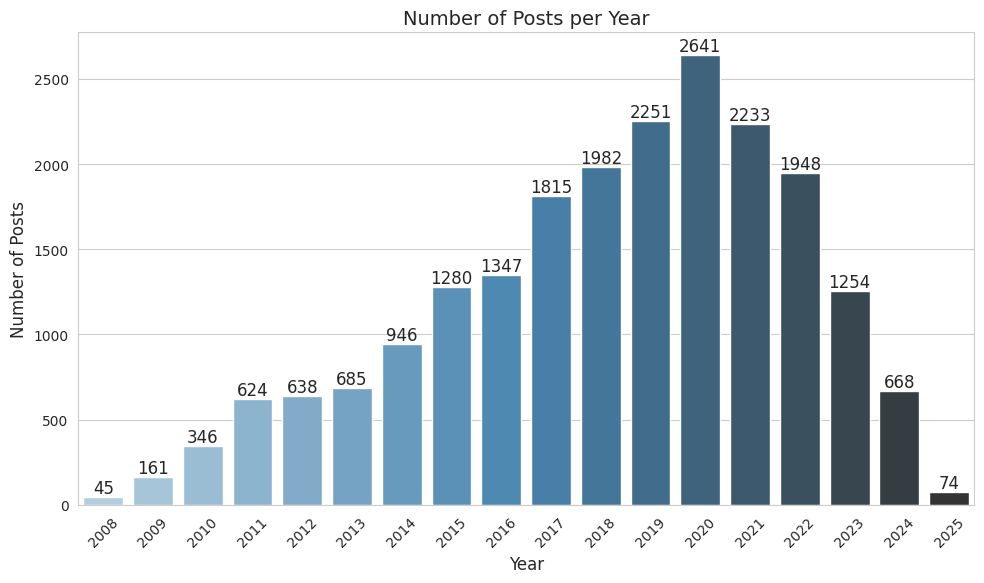

In [ ]:
# ==================== Posts per Year ====================
df_valid_dates = df_raw[df_raw['post_date'].notna()]
if not df_valid_dates.empty:
    df_valid_dates['year'] = df_valid_dates['post_date'].dt.year
    posts_per_year = df_valid_dates['year'].value_counts().sort_index()

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=posts_per_year.index, y=posts_per_year.values, hue=posts_per_year.index, palette='Blues_d', legend=False)
    plt.title('Number of Posts per Year')
    plt.xlabel('Year')
    plt.ylabel('Number of Posts')
    plt.xticks(rotation=45)
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom')
    plt.tight_layout()
    plt.savefig('visualizations/9_posts_per_year.png')
    plt.show()
    plt.close()
else:
    print("Warning: No valid 'post_date' values available. Skipping posts per year visualization.")



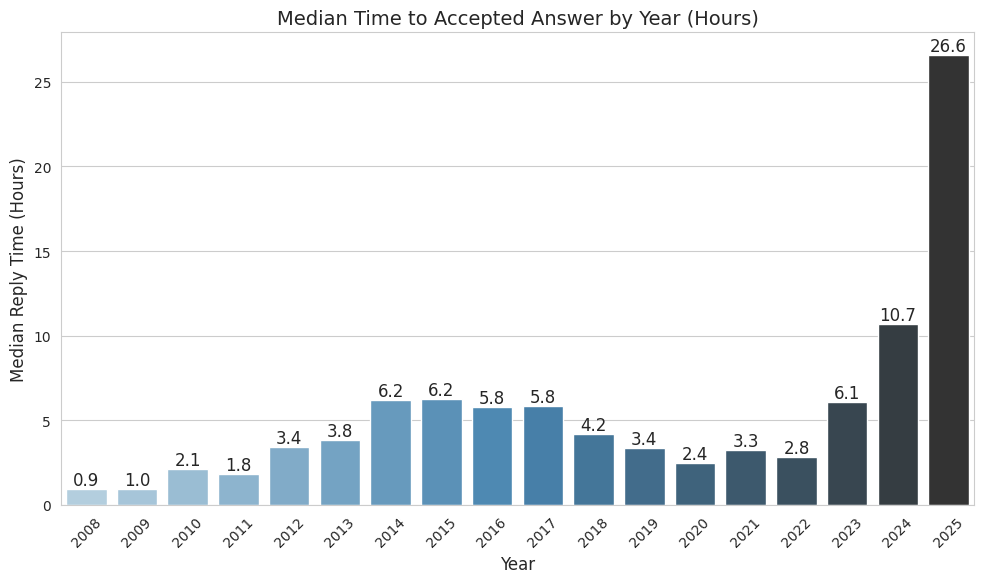

In [ ]:
# ==================== Median Time to Reply ====================
df_reply_time = df_valid_dates[df_valid_dates['accepted_answer_date'].notna()].copy()
if not df_reply_time.empty:
    df_reply_time['reply_time'] = (df_reply_time['accepted_answer_date'] - df_reply_time['post_date']).dt.total_seconds() / 3600  # Convert to hours
    df_reply_time['year'] = df_reply_time['post_date'].dt.year
    median_reply_time = df_reply_time.groupby('year')['reply_time'].median()

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=median_reply_time.index, y=median_reply_time.values, hue=median_reply_time.index, palette='Blues_d', legend=False)
    plt.title('Median Time to Accepted Answer by Year (Hours)')
    plt.xlabel('Year')
    plt.ylabel('Median Reply Time (Hours)')
    plt.xticks(rotation=45)
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.1f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom')
    plt.tight_layout()
    plt.savefig('visualizations/10_median_reply_time.png')
    plt.show()
    plt.close()
else:
    print("Warning: No valid 'accepted_answer_date' values available. Skipping median reply time visualization.")



<Figure size 1000x600 with 0 Axes>

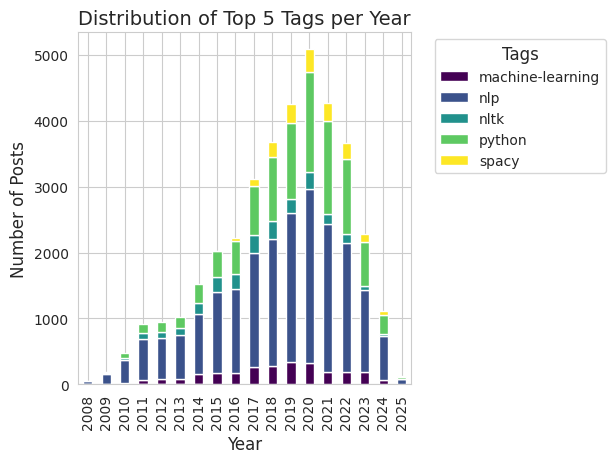

In [ ]:
# ==================== Category Evaluation Over Time (Stacked Bar) ====================
if not df_valid_dates.empty:
    top_tags = df_valid_dates['tags'].str.split(';', expand=True).stack().value_counts().head(5).index
    df_exploded = df_valid_dates.assign(tags=df_valid_dates['tags'].str.split(';')).explode('tags')
    tag_year_counts = df_exploded[df_exploded['tags'].isin(top_tags)].groupby(['year', 'tags']).size().unstack(fill_value=0)

    plt.figure(figsize=(10, 6))
    tag_year_counts.plot(kind='bar', stacked=True, colormap='viridis')
    plt.title('Distribution of Top 5 Tags per Year')
    plt.xlabel('Year')
    plt.ylabel('Number of Posts')
    plt.legend(title='Tags', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('visualizations/11_tags_per_year_stacked.png')
    plt.show()
    plt.close()
else:
    print("Warning: No valid 'post_date' values available. Skipping category evaluation over time.")



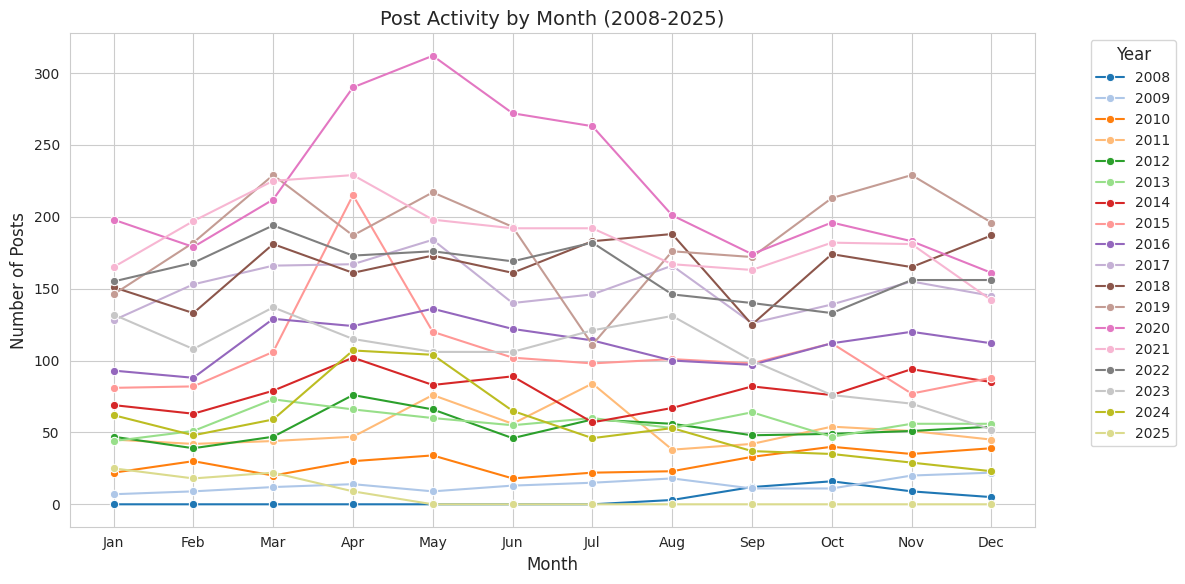

In [ ]:
# ==================== Post Activity by Month ====================
if not df_valid_dates.empty:
    df_valid_dates['year'] = df_valid_dates['post_date'].dt.year
    df_valid_dates['month'] = df_valid_dates['post_date'].dt.month
    year_range = df_valid_dates['year'].dropna().astype(int).unique()
    title = f"Post Activity by Month ({min(year_range)}-{max(year_range)})" if len(year_range) > 1 else f"Post Activity by Month ({year_range[0]})"

    month_year_counts = df_valid_dates.groupby(['month', 'year']).size().unstack(fill_value=0)
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    # Define colors for each year
    colors = sns.color_palette('tab20', n_colors=len(month_year_counts.columns))

    plt.figure(figsize=(12, 6))
    for idx, year in enumerate(month_year_counts.columns):
        sns.lineplot(x=month_names, y=month_year_counts[year], marker='o', label=year, color=colors[idx])
    plt.title(title)
    plt.xlabel('Month')
    plt.ylabel('Number of Posts')
    plt.xticks(rotation=0)
    plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('visualizations/12_posts_per_month.png')
    plt.show()
    plt.close()
else:
    print("Warning: No valid 'post_date' values available. Skipping post activity by month visualization.")



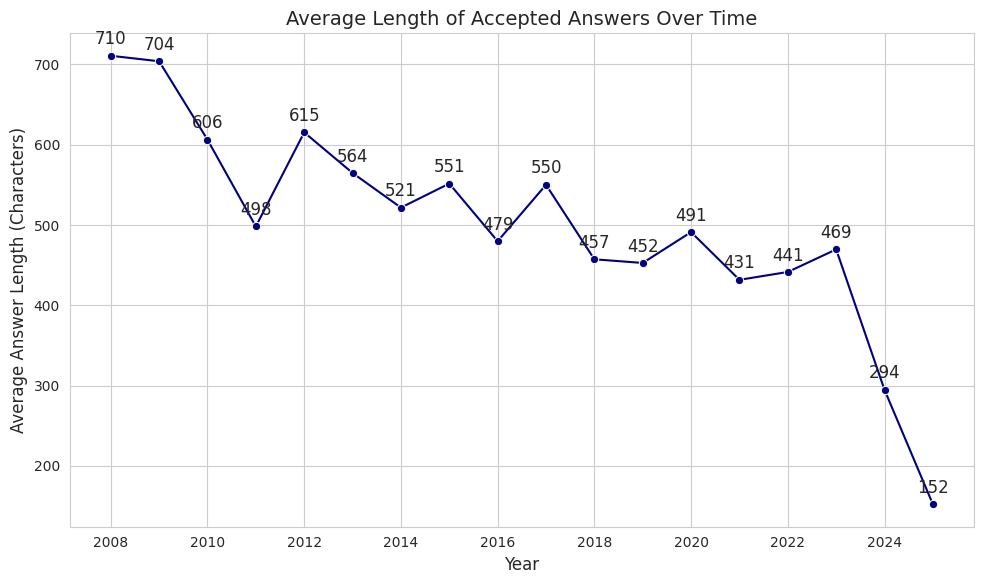

In [ ]:
# ==================== Average Accepted Answer Length Over Time ====================
if not df_valid_dates.empty:
    df_valid_dates['answer_length'] = df_valid_dates['accepted_answer'].astype(str).apply(len)
    df_valid_dates['year'] = df_valid_dates['post_date'].dt.year
    avg_answer_length = df_valid_dates.groupby('year')['answer_length'].mean()

    plt.figure(figsize=(10, 6))

    # Plot the line with markers (using existing style settings)
    sns.lineplot(x=avg_answer_length.index, y=avg_answer_length.values,
                 marker='o', color='navy')

    plt.title('Average Length of Accepted Answers Over Time')
    plt.xlabel('Year')
    plt.ylabel('Average Answer Length (Characters)')

    # Fix for x-axis - ensure integers only
    ax = plt.gca()
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

    # Add data labels
    for i, v in enumerate(avg_answer_length.values):
        plt.text(avg_answer_length.index[i], v + max(avg_answer_length.values)*0.02,
                 f'{int(v)}', ha='center')

    plt.grid(True)
    plt.tight_layout()
    plt.savefig('visualizations/13_avg_answer_length.png')
    plt.show()
    plt.close()
else:
    print("Warning: No valid 'post_date' values available. Skipping average answer length visualization.")

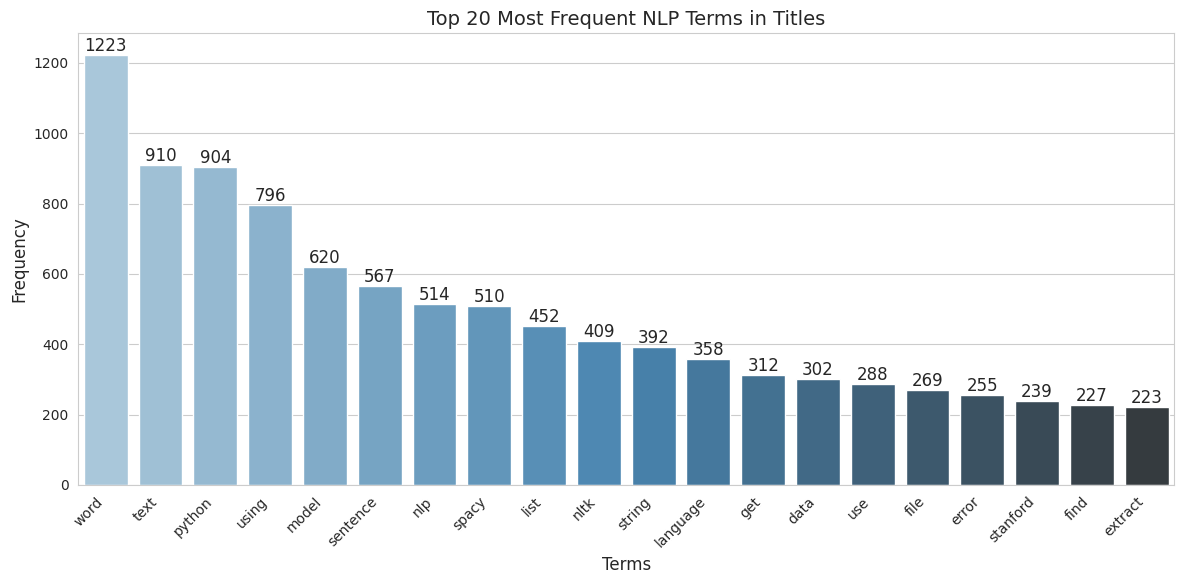

In [ ]:

# ==================== Top NLP Terms Bar Chart ====================
all_title_words = ' '.join(df_preprocessed['title'].dropna()).split()
word_freq = Counter(all_title_words)
top_words = word_freq.most_common(20)

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=[word[0] for word in top_words], y=[word[1] for word in top_words], hue=[word[0] for word in top_words], palette='Blues_d', legend=False)
plt.title('Top 20 Most Frequent NLP Terms in Titles')
plt.xlabel('Terms')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom')
plt.tight_layout()
plt.savefig('visualizations/3_top_terms_barchart.png')
plt.show()
plt.close()

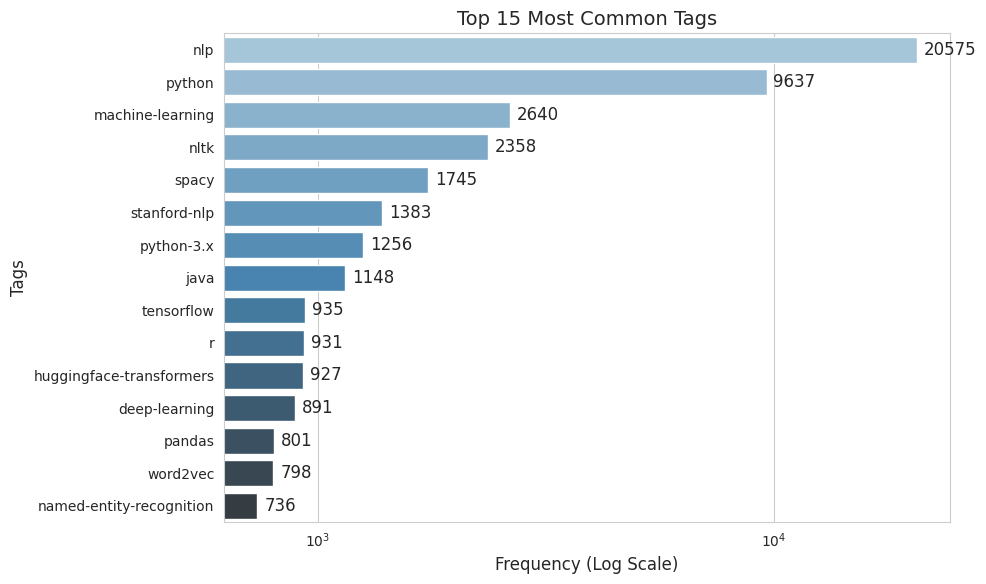

In [ ]:
# ==================== Tag Frequency Bar Chart ====================
tag_freq = df_raw['tags'].str.split(';', expand=True).stack().value_counts()
top_15_tags = tag_freq.head(15)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=top_15_tags.values, y=top_15_tags.index, hue=top_15_tags.index, palette='Blues_d', legend=False)
plt.title('Top 15 Most Common Tags')
plt.xlabel('Frequency (Log Scale)')
plt.ylabel('Tags')
plt.xscale('log')
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}', (p.get_width(), p.get_y() + p.get_height() / 2.),
                ha='left', va='center', xytext=(5, 0), textcoords='offset points')
plt.tight_layout()
plt.savefig('visualizations/5_tag_frequency.png')
plt.show()
plt.close()



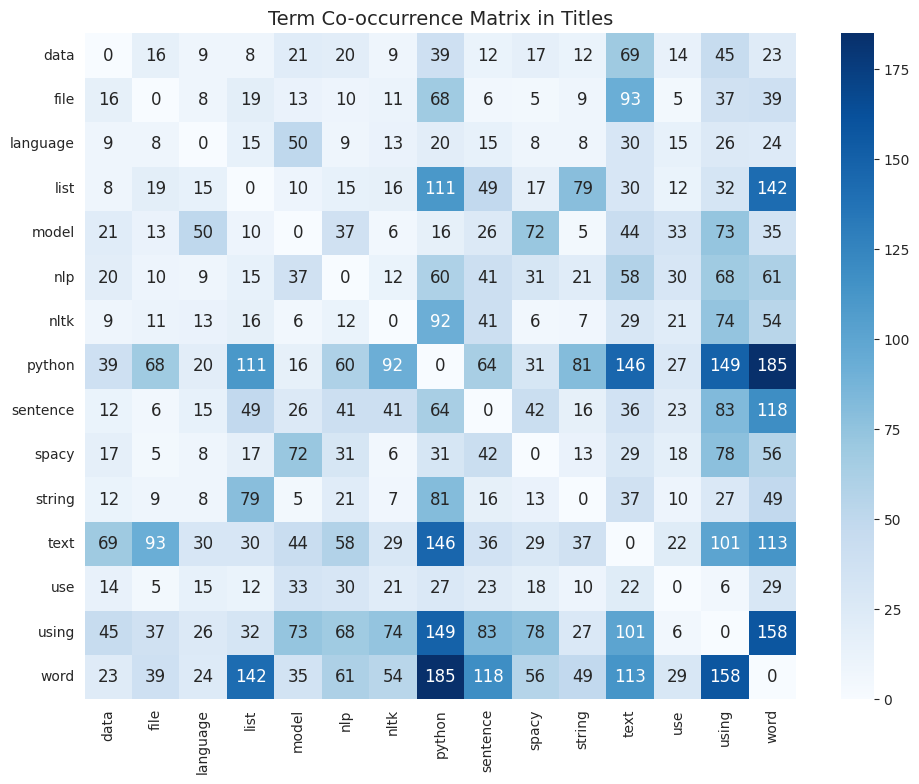

In [ ]:
# ==================== Term Co-occurrence Heatmap ====================
vectorizer = CountVectorizer(max_features=15, stop_words='english')
X = vectorizer.fit_transform(df_preprocessed['title'].dropna())
terms = vectorizer.get_feature_names_out()

co_matrix = (X.T @ X).toarray()
np.fill_diagonal(co_matrix, 0)

plt.figure(figsize=(10, 8))
sns.heatmap(co_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=terms, yticklabels=terms)
plt.title('Term Co-occurrence Matrix in Titles')
plt.tight_layout()
plt.savefig('visualizations/6_term_cooccurrence.png')
plt.show()
plt.close()



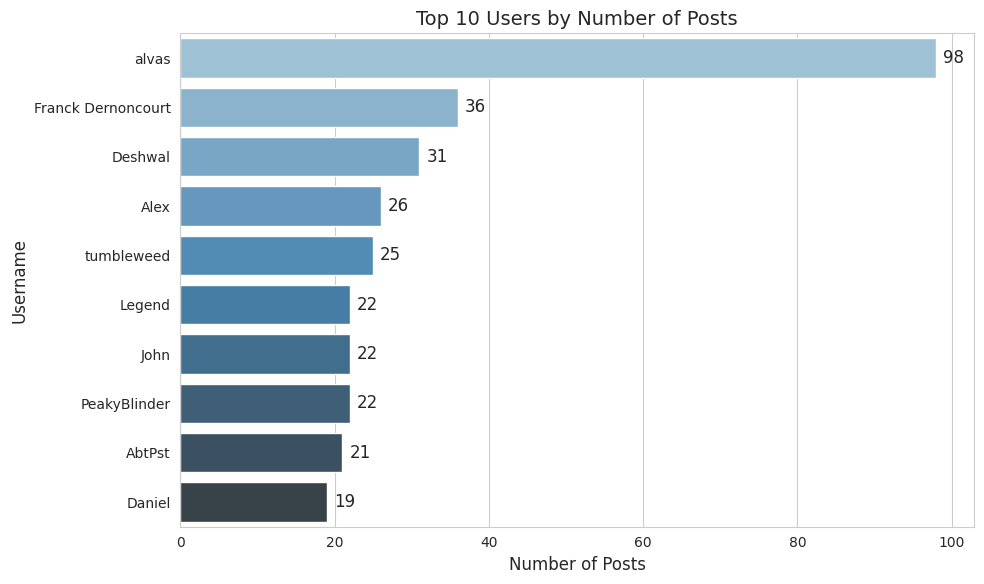

In [ ]:
# ==================== Top Users by Post Count ====================
top_users = df_raw['post_username'].value_counts().head(10)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=top_users.values, y=top_users.index, hue=top_users.index, palette='Blues_d', legend=False)
plt.title('Top 10 Users by Number of Posts')
plt.xlabel('Number of Posts')
plt.ylabel('Username')
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}', (p.get_width(), p.get_y() + p.get_height() / 2.),
                ha='left', va='center', xytext=(5, 0), textcoords='offset points')
plt.tight_layout()
plt.savefig('visualizations/14_top_users.png')
plt.show()
plt.close()



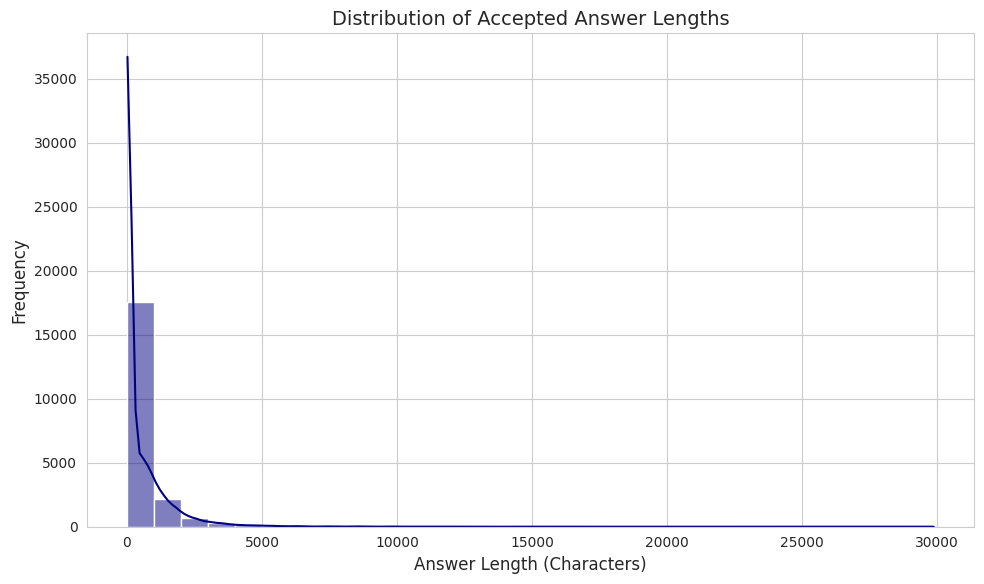

In [ ]:
# ==================== Accepted Answer Length Distribution ====================
if not df_valid_dates.empty:
    answer_lengths = df_valid_dates['accepted_answer'].astype(str).apply(len)

    plt.figure(figsize=(10, 6))
    sns.histplot(answer_lengths, bins=30, color='navy', kde=True)
    plt.title('Distribution of Accepted Answer Lengths')
    plt.xlabel('Answer Length (Characters)')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.savefig('visualizations/15_answer_length_distribution.png')
    plt.show()
    plt.close()
else:
    print("Warning: No valid 'accepted_answer' values available. Skipping answer length distribution visualization.")

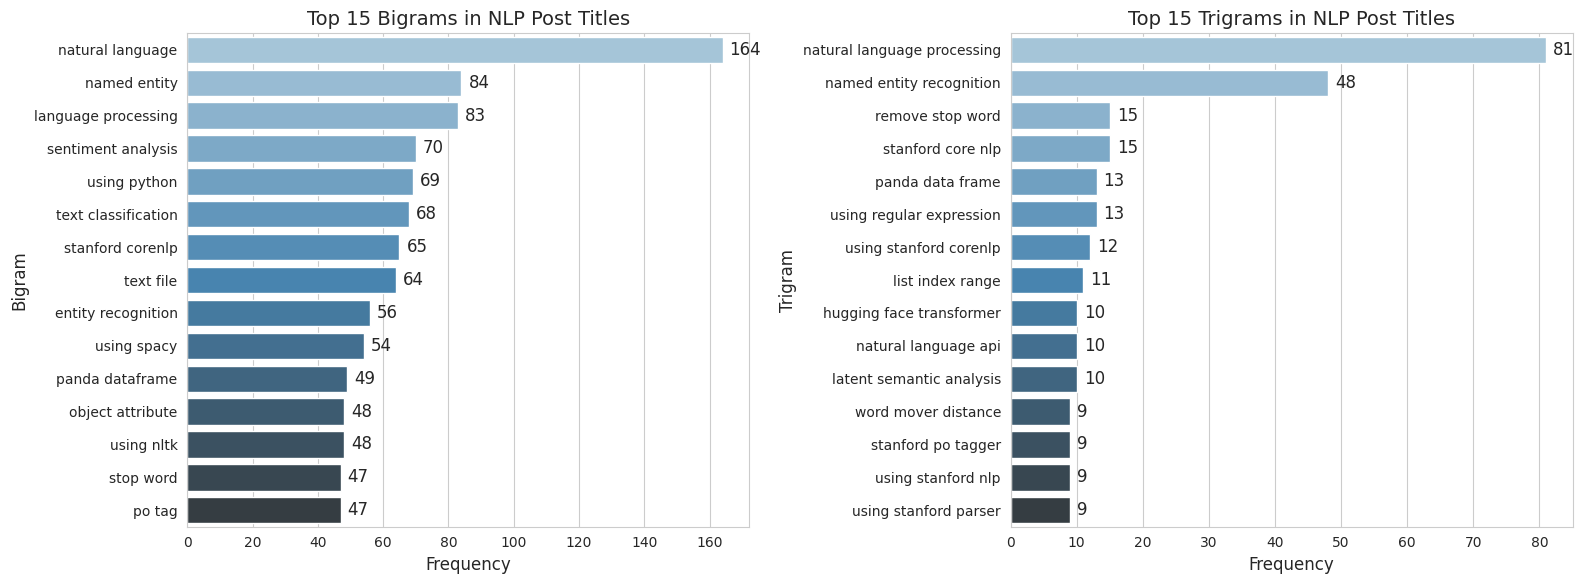

In [ ]:
# ==================== Combined Bigrams and Trigrams Visualization ====================
def get_bigrams(text):
    tokens = word_tokenize(text)
    return list(nltk.bigrams(tokens))

def get_trigrams(text):
    tokens = word_tokenize(text)
    return list(nltk.trigrams(tokens))

# Compute bigrams
all_bigrams = []
for title in df_preprocessed['title'].dropna():
    all_bigrams.extend(get_bigrams(title))
bigram_freq = Counter(all_bigrams)
top_bigrams = bigram_freq.most_common(15)

# Compute trigrams
all_trigrams = []
for title in df_preprocessed['title'].dropna():
    all_trigrams.extend(get_trigrams(title))
trigram_freq = Counter(all_trigrams)
top_trigrams = trigram_freq.most_common(15)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Bigrams plot
sns.barplot(x=[bg[1] for bg in top_bigrams], y=[' '.join(bg[0]) for bg in top_bigrams], ax=ax1, hue=[' '.join(bg[0]) for bg in top_bigrams], palette='Blues_d', legend=False)
ax1.set_title('Top 15 Bigrams in NLP Post Titles')
ax1.set_xlabel('Frequency')
ax1.set_ylabel('Bigram')
for p in ax1.patches:
    ax1.annotate(f'{int(p.get_width())}', (p.get_width(), p.get_y() + p.get_height() / 2.),
                 ha='left', va='center', xytext=(5, 0), textcoords='offset points')

# Trigrams plot
sns.barplot(x=[tg[1] for tg in top_trigrams], y=[' '.join(tg[0]) for tg in top_trigrams], ax=ax2, hue=[' '.join(tg[0]) for tg in top_trigrams], palette='Blues_d', legend=False)
ax2.set_title('Top 15 Trigrams in NLP Post Titles')
ax2.set_xlabel('Frequency')
ax2.set_ylabel('Trigram')
for p in ax2.patches:
    ax2.annotate(f'{int(p.get_width())}', (p.get_width(), p.get_y() + p.get_height() / 2.),
                 ha='left', va='center', xytext=(5, 0), textcoords='offset points')

plt.tight_layout()
plt.savefig('visualizations/8_bigrams_trigrams_combined.png')
plt.show()
plt.close()

# Categorisation

In [ ]:
# ---------------------------------SENTENCE-LEVEL CATEGORISATION-----------------------------------------
# Load the preprocessed dataset
df = pd.read_excel("nlp_stackoverflow_processed.xlsx", sheet_name="Preprocessed_Data")

# Verify that required columns exist
required_columns = ['post_id', 'title', 'description', 'post_link', 'post_date']
if not all(col in df.columns for col in required_columns):
    missing = [col for col in required_columns if col not in df.columns]
    raise ValueError(f"Missing columns in the dataset: {missing}")

# Combining title + description
df['text'] = df['title'].astype(str) + " " + df['description'].astype(str)

# Additional preprocessing for text used in categorization to deal with website links (format -> https://www.website.com/article/path)
def clean_text(text):
    if pd.isna(text) or text.strip() == "":
        return ""
    # Preserve sentence boundaries
    text = re.sub(r'http[s]?[^\s]+', ' URL ', text)  # Replace URLs with placeholder
    text = re.sub(r'quot[^ ]+pyquot', '', text)
    text = re.sub(r'[^ ]+[/\\][^ ]+', '', text)
    text = re.sub(r'\b\w*\d+\w*\b', '', text)
    # Handle SO markup and newlines
    text = re.sub(r'<p>|\n+|\r+|[*+-]\s+', '. ', text)
    # Normalize punctuation
    text = re.sub(r'\s*([.!?])\s*', r'\1 ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Split text into sentences and create a sentence-level dataframe
def create_sentence_df(df, use_spacy=False):
    sentence_data = []
    sentence_id = 0  # Initialize sentence counter

    for _, row in df.iterrows():
        post_id = row['post_id']
        raw_text = row['text']
        cleaned_text = clean_text(raw_text)
        sentences = nltk.sent_tokenize(cleaned_text)
        # Fallback: Regex split if it produces one sentence
        if len(sentences) <= 1:
            sentences = [s.strip() for s in re.split(r'[.!?]+\s+', cleaned_text) if s.strip()]

        pre_filter_count = len(sentences)
        filtered_sentences = 0

        for sent_idx, sentence in enumerate(sentences):
            # Relaxed filter: Include sentences with > 1 word
            if len(sentence.split()) > 1:
                sentence_data.append({
                    'sentence_id': sentence_id,  # Add unique sentence ID
                    'post_id': post_id,
                    'sentence_idx': sent_idx,  # Keep this for reference
                    'sentence': sentence,
                    'title': row['title'],
                    'description': row['description'],
                    'post_link': row['post_link'],
                    'post_date': row['post_date']
                })
                sentence_id += 1  # Increment the sentence ID
                filtered_sentences += 1
            else:
                print(f"Post {post_id}, Sentence {sent_idx}: Skipped (too short: '{sentence}')")

    sentence_df = pd.DataFrame(sentence_data)

    # Check sentence count
    print(f"\nTotal unique sentences in dataset: {len(sentence_df)}")
    print(f"Sentence IDs range from 0 to {len(sentence_df)-1}")

    return sentence_df

sentence_df = create_sentence_df(df, use_spacy=False)

# Vectorize sentences using TF-IDF
vectorizer = TfidfVectorizer(max_df=0.8, min_df=5, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(sentence_df['sentence'])

# Apply K-Means clustering with 12 clusters
n_clusters = 12
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
sentence_df['category'] = kmeans.fit_predict(tfidf_matrix)

# Initialize KeyBERT model
kw_model = KeyBERT()

# Function to extract keywords
def extract_keywords(text, top_n=10):
    if pd.isna(text) or text.strip() == "":
        return []
    keywords = kw_model.extract_keywords(
        text,
        keyphrase_ngram_range=(1, 2),
        stop_words='english',
        top_n=top_n
    )
    filtered_keywords = [
        kw[0] for kw in keywords
        if not re.search(r'\d', kw[0]) and '/' not in kw[0] and 'quot' not in kw[0]
    ]
    return filtered_keywords[:top_n]

# Extract keywords for each sentence cluster
category_keywords = {}
for category in sentence_df['category'].unique():
    category_texts = sentence_df[sentence_df['category'] == category]['sentence'].head(100).str.cat(sep=' ')
    keywords = extract_keywords(category_texts, top_n=10)
    category_keywords[category] = keywords
    print(f"Category: Cluster {category}")
    print(f"Keywords: {keywords}\n")

# Updated category rules
category_rules = {
    "Coding Errors": {'error': 4, 'exception': 4, 'traceback': 4, 'fail': 3, 'bug': 3, 'indexing': 3, 'cmake': 3, 'make': 3},
    "Library-Specific Issues": {'nltk': 5, 'spacy': 5, 'huggingface': 5, 'transformers': 5, 'tensorflow': 5, 'bert': 5, 'opennlp': 5, 'glove': 5, 'bertopic': 5, 'openaiembeddings': 5},
    "Model Performance Issues": {'model': 3, 'accuracy': 3, 'performance': 3, 'training': 3, 'loss': 3, 'lstm': 3, 'underfitting': 3, 'retrain': 3, 'sequential': 2, 'optimizer': 3},
    "Tokenization/Chunking Issues": {'tokenize': 4, 'tokenizer': 4, 'chunking': 4, 'chunker': 4, 'pretrained': 3, 'split': 3, 'segment': 3},
    "Vocabulary/Word List Issues": {'word': 4, 'list': 4, 'wordlist': 4, 'sentencewords': 3, 'embedding': 4, 'wordvectors': 4, 'vector': 3, 'vocabulary': 4},
    "Keyword Extraction Issues": {'keyword': 4, 'extraction': 4, 'extracting': 4, 'topics': 3, 'term_frequency': 3, 'tfidf': 4, 'topic': 3},
    "Multiprocessing/Optimization Issues": {'multiprocessing': 5, 'shared_memory': 4, 'efficient': 3, 'nlppipe': 3, 'parallel': 4, 'speed': 3, 'optimization': 4},
    "Sentiment Analysis Issues": {'sentiment': 4, 'classification': 4, 'classifier': 4, 'analysis': 3, 'emotion': 4, 'positive': 3, 'negative': 3},
    "Infrastructure/Storage Issues": {'aws': 4, 'store': 4, 'file': 3, 'image': 3, 'batch': 3, 'database': 4, 'cloud': 3, 'save': 3},
    "Training-Related Errors": {'error': 4, 'training': 3, 'train_data': 3, 'train_loop': 3, 'dataset_train': 3, 'epoch': 3, 'batch_size': 3},
    "Text Preprocessing Issues": {'preprocess': 4, 'clean': 4, 'normalize': 4, 'lowercase': 3, 'remove': 3, 'stopword': 4, 'lemmatize': 4, 'stem': 3},
    "Language Translation Issues": {'translate': 4, 'translation': 4, 'language': 3, 'multilingual': 4, 'cross-lingual': 4, 'nmt': 4},
    "Named Entity Recognition Issues": {'ner': 5, 'entity': 4, 'named': 3, 'recognition': 3, 'person': 3, 'location': 3, 'organization': 3},
    "Question Answering Issues": {'question': 4, 'answer': 4, 'qa': 5, 'context': 3, 'squad': 4, 'answering': 4},
    "Dependency Parsing Issues": {'dependency': 4, 'parsing': 4, 'parse': 4, 'tree': 3, 'syntax': 3, 'grammar': 3}
    }

def assign_category(keywords):
    keywords_lower = [kw.lower() for kw in keywords]
    category_scores = {cat: 0 for cat in category_rules}
    match_details = {cat: [] for cat in category_rules}
    keyword_matches = {cat: {} for cat in category_rules}  # Track individual keyword matches

    # Step 1: Calculate initial scores and track matches
    for cat, rule_dict in category_rules.items():
        for kw in keywords_lower:
            for rk, weight in rule_dict.items():
                if rk in kw or kw in rk:
                    category_scores[cat] += weight
                    match_details[cat].append(f"{rk} (w={weight}) in {kw}")
                    # Count keyword matches
                    if rk not in keyword_matches[cat]:
                        keyword_matches[cat][rk] = 0
                    keyword_matches[cat][rk] += 1

    # Find highest score and any ties
    max_score = max(category_scores.values()) if category_scores else 0
    best_categories = [cat for cat, score in category_scores.items() if score == max_score]

    print(f"Keywords: {keywords}")
    print(f"Scores: {category_scores}")

    if max_score == 0:
        return "Miscellaneous Issues"
    elif len(best_categories) == 1:
        return best_categories[0]
    else:
        print(f"Tie detected between: {best_categories}")

        # Step 2: Calculate tie-breaking metrics
        tiebreaker_metrics = {}

        for cat in best_categories:
            # Metric 1: Total frequency count (how many keyword matches)
            total_frequency = sum(keyword_matches[cat].values())

            # Metric 2: Unique keyword rule matches (how many different rules matched)
            unique_matches = len(keyword_matches[cat])

            # Metric 3: Highest individual keyword weight
            highest_weight = max([rule_dict.get(kw, 0) for kw in keyword_matches[cat]
                                 for rule_dict in [category_rules[cat]]])

            # Metric 4: Exact match bonus (prefer exact matches over partial)
            exact_match_count = sum(1 for kw in keywords_lower
                                   for rule_kw in category_rules[cat]
                                   if kw == rule_kw)

            # Metric 5: Average match length (prefer longer keyword matches)
            match_lengths = [len(match_kw) for match_kw in keyword_matches[cat]]
            avg_match_length = sum(match_lengths) / len(match_lengths) if match_lengths else 0

            tiebreaker_metrics[cat] = {
                "total_frequency": total_frequency,
                "unique_matches": unique_matches,
                "highest_weight": highest_weight,
                "exact_match_count": exact_match_count,
                "avg_match_length": avg_match_length,
                "composite_score": (total_frequency * 0.4 +
                                   unique_matches * 0.25 +
                                   highest_weight * 0.15 +
                                   exact_match_count * 0.1 +
                                   avg_match_length * 0.1)
            }

        # Log all metrics
        for cat, metrics in tiebreaker_metrics.items():
            print(f"Category '{cat}' tiebreaker metrics:")
            for metric_name, value in metrics.items():
                print(f"  - {metric_name}: {value}")

        # Choose the winner based on composite score
        best_category = max(tiebreaker_metrics, key=lambda x: tiebreaker_metrics[x]["composite_score"])
        print(f"Selected '{best_category}' with highest composite score: {tiebreaker_metrics[best_category]['composite_score']:.3f}")

        return best_category

# Assign category names
keyword_to_category = {}
for cluster, keywords in category_keywords.items():
    category_name = assign_category(keywords)
    keyword_to_category[cluster] = category_name
    print(f"Cluster {cluster} assigned to: {category_name}\n")

# Map cluster numbers to category names in sentence_df
sentence_df['category_name'] = sentence_df['category'].map(keyword_to_category)

# After mapping clusters to categories
cluster_category_map = pd.DataFrame({
    'Cluster': list(keyword_to_category.keys()),
    'Category': list(keyword_to_category.values())
})
print("\nCluster to Category Mapping:")
print(cluster_category_map)

# Checking categories used
used_categories = set(keyword_to_category.values())
all_categories = set(category_rules.keys())
unused_categories = all_categories - used_categories

print(f"\nTotal defined categories: {len(all_categories)}")
print(f"Categories used in classification: {len(used_categories)}")
print(f"Unused categories: {unused_categories}")

# Check distribution
print("\nCategory Distribution:")
print(sentence_df['category_name'].value_counts())

# Save sentence-level results
with pd.ExcelWriter("nlp_stackoverflow_categorized_sentences.xlsx", engine='openpyxl') as writer:
    sentence_df.to_excel(writer, sheet_name='Sentence_Level', index=False)

with open("sentence_category_keywords.txt", "w") as f:
    for category, keywords in category_keywords.items():
        cat_name = keyword_to_category[category]
        f.write(f"Category: {cat_name}\n")
        f.write(f"Keywords: {', '.join(keywords)}\n\n")

print("Saved sentence-level dataset to 'nlp_stackoverflow_categorized_sentences.xlsx'")
print("Saved categories and keywords to 'sentence_category_keywords.txt'")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



Total unique sentences in dataset: 7750
Sentence IDs range from 0 to 7749
Category: Cluster 2
Keywords: ['nlp spacyloadde_core_news_sm', 'nlp spacyloaden_core_web_lg', 'nlp spacyloaden_core_web_sm', 'spacyclidownloaden_core_web_sm nlp', 'spacy nlpspacyloaden_core_web_sm', 'nlp_g spacyloaden_core_web_lg', 'nlp_engine_name spacy']

Category: Cluster 3
Keywords: ['train lstm', 'autotokenizerfrom_pretrainedmodel_id tokenizer_no_pad', 'token training', 'tokenizer_no_pad autotokenizerfrom_pretrainedmodel_id', 'training word', 'training_sequencethe_model', 'glove lstm', 'trainingdataset tokenize', 'predicted_tokens tokenizerdecodetoken_idstrip', 'trainingarguments config']

Category: Cluster 5
Keywords: ['gensimsimilarities import', 'gensimparsingpreprocessing import', 'gensimmodels import', 'gensim import', 'import gensim', 'importing gensim', 'sentence_transformers import', 'import corpus', 'importerror import']

Category: Cluster 7
Keywords: ['opennlp chunking', 'improving chunker', 'mode

In [ ]:
# Read the categorized data from nlp_stackoverflow_categorized.xlsx
categorized_df = pd.read_excel("/content/nlp_stackoverflow_categorized_sentences.xlsx", sheet_name="Sentence_Level")

# Append the categorized data as a new sheet in nlp_stackoverflow_processed.xlsx
with pd.ExcelWriter("/content/nlp_stackoverflow_processed.xlsx", engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    categorized_df.to_excel(writer, sheet_name='Sentence_Level_Categorization', index=False)

print("Appended categorized data as 'Categorized_Data' sheet in 'nlp_stackoverflow_processed.xlsx'")

Appended categorized data as 'Categorized_Data' sheet in 'nlp_stackoverflow_processed.xlsx'


In [ ]:
# Load the categorized dataset
df = pd.read_excel("/content/nlp_stackoverflow_processed.xlsx", sheet_name="Sentence_Level_Categorization")

# Ensure relevant columns exist
required_columns = ['post_id', 'title', 'description', 'post_link', 'post_date', 'category', 'category_name']
if not all(col in df.columns for col in required_columns):
    missing = [col for col in required_columns if col not in df.columns]
    raise ValueError(f"Missing columns in the dataset: {missing}")

# Group by category_name and display 3 examples per category
for category_name, group in df.groupby('category_name'):
    print(f"\nCategory: {category_name}")
    print(f"Number of posts: {len(group)}")
    print("-" * 50)

    examples = group[required_columns].head(3)

    for idx, row in examples.iterrows():
        print(f"Example {idx + 1}:")
        print(f"Post ID: {row['post_id']}")
        print(f"Title: {row['title']}")
        print(f"Description: {row['description'][:200]}...")  # Truncate for readability
        print(f"Link: {row['post_link']}")
        print(f"Date: {row['post_date']}")
        print(f"Cluster: {row['category']}")
        print("-" * 50)


Category: Coding Errors
Number of posts: 161
--------------------------------------------------
Example 7:
Post ID: 79330283
Title: cant compile marian nmt
Description: im using endeavouros im trying compile marian instruction httpsmariannmtgithubiodocsinstallation fails error message seemingly indicates conflict code c20 cmakeliststxt file repo line set cmake_cxx_st...
Link: https://stackoverflow.com/questions/79330283/cant-compile-marian-nmt
Date: 2025-01-05 06:04:59
Cluster: 8
--------------------------------------------------
Example 27:
Post ID: 79057082
Title: avoiding overlap frequency document frequency count quanteda
Description: dummy corpus 4 document dictionary developed identify frequency word phrase corpus well number document word phrase occurs world australian occurs two dictionary key peep indig key content intended mu...
Link: https://stackoverflow.com/questions/79057082/avoiding-overlap-in-frequency-and-document-frequency-count-in-quanteda
Date: 2024-10-05 12:43:52
